# PMFG -- testing runtime and convergence

In [2]:
import numpy as np
import pandas as pd
import networkx # as nx

from time import time
import timeit

#%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')
log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
# drop first row of raw prices so it has the same dimensions as the log-returns DF
raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
stock_names = log_returns_df.columns

df_shape = (raw_asset_prices_df.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")


There are 251 rows and 504 columns in the dataset.
Data timeperiod covers: 2020/6/22 to 2021/6/18


In [4]:
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
#shr_target=np.ones((df_shape[1], df_shape[1]))
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))

G0 = networkx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
print(networkx.info(G0))

Condition number of sample correlation matrix: 1.13e+19
Condition number of shrunk correlation matrix: 1.49e+06
Name: 
Type: Graph
Number of nodes: 504
Number of edges: 126756
Average degree: 503.0000


## Diagnostic version of PMFG.py
Temporary version of PMFG algorithm for debugging, as well as inspecting the convergence process.

In [11]:
from typing import List
import planarity

class edge():
    """
    Create an edge from `src` to `dst` with weight `wt`

    @params
    src: source node
    dst: destination node
    wt: weight
    """
    def __init__(self, src, dst, wt):
        self.src = src
        self.dst = dst
        self.wt = wt

class PMFG():

    def __init__(self, graph: networkx.Graph, planarity_check_lib: str="default", verbose: int=0, tol_ratio: float=0.):
        self.origin_graph = graph
        self.sort_edges = None
        self.pmfg_graph = None
        self.planarity_check_lib = planarity_check_lib
        self.verbose = verbose
        self.tol_ratio = tol_ratio

    def sort_edge(self) -> List[edge]:
        sort_edges = []
        for src, dst, data in sorted(self.origin_graph.edges(data=True), key=lambda x: x[2]["weight"], reverse=True):
            sort_edges.append(edge(src, dst, data["weight"]))
        self.sort_edges = sort_edges
        return sort_edges
    
    
    def compute(self) -> networkx.Graph:
        if self.sort_edges == None:
            self.sort_edge()
        number_of_nodes = self.origin_graph.number_of_nodes()
        pmfg_graph = networkx.Graph()
        
        loop_counter = 0
        cum_pct = []
        timestamp = time()
        for edge in self.sort_edges:
            loop_counter += 1
            # Adding edge and check the planarity
            pmfg_graph.add_edge(edge.src, edge.dst, weight=edge.wt)
            # If the graph is not planar, then remove the edge
            if not self.is_planar(pmfg_graph, self.planarity_check_lib):
                pmfg_graph.remove_edge(edge.src, edge.dst)
            cum_pct.append(pmfg_graph.number_of_edges()/(3 * (number_of_nodes - 2)))
            if self.verbose == 1:
                    print(f"Number of edges added = {pmfg_graph.number_of_edges()}, Number of edges to be added = {3 * (number_of_nodes - 2) - pmfg_graph.number_of_edges()}")
            if self.verbose == 2 and (loop_counter%1000 == 0):
                    print(f"Number of edges to be added = {3 * (number_of_nodes - 2) - pmfg_graph.number_of_edges()}, time taken = {time() - timestamp}")
                    timestamp = time()
            if pmfg_graph.number_of_edges() >= 3 * (number_of_nodes - 2) * (1-self.tol_ratio):
                break
        self.pmfg_graph = pmfg_graph
        return pmfg_graph, np.array(cum_pct)

    @staticmethod
    def is_planar(graph: networkx.Graph, planarity_check_lib: str="default") -> bool:
        if planarity_check_lib == "networkx":
            return networkx.algorithms.planarity.check_planarity(graph)[0]
        return planarity.is_planar(graph)

In [12]:
#timestamp = time()
G0_filtered, cum_pct = PMFG(G0, verbose=2).compute()
#print('Time taken to construct PMFG graph: %.2f s\n' %(time()-timestamp))


Number of edges to be added = 1078, time taken = -0.32239818572998047
Number of edges to be added = 854, time taken = -0.6372208595275879
Number of edges to be added = 735, time taken = -0.7996914386749268
Number of edges to be added = 646, time taken = -0.7931435108184814
Number of edges to be added = 569, time taken = -0.8813681602478027
Number of edges to be added = 496, time taken = -0.9494647979736328
Number of edges to be added = 455, time taken = -1.0266516208648682
Number of edges to be added = 408, time taken = -1.016768455505371
Number of edges to be added = 373, time taken = -1.076981782913208
Number of edges to be added = 336, time taken = -1.0991573333740234
Number of edges to be added = 306, time taken = -1.1556527614593506
Number of edges to be added = 279, time taken = -1.1950552463531494
Number of edges to be added = 260, time taken = -1.1912755966186523
Number of edges to be added = 240, time taken = -1.2315614223480225
Number of edges to be added = 222, time taken = 

NameError: name 'nx' is not defined

In [13]:
print(networkx.info(G0_filtered))

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 1506
Average degree:   5.9762


In [36]:
for i in range(95, 100):
    print(i,'pct: argmin' , np.min(np.where(cum_pct>=i*.01)))

95 pct: argmin 29698
96 pct: argmin 32696
97 pct: argmin 36598
98 pct: argmin 41716
99 pct: argmin 51153


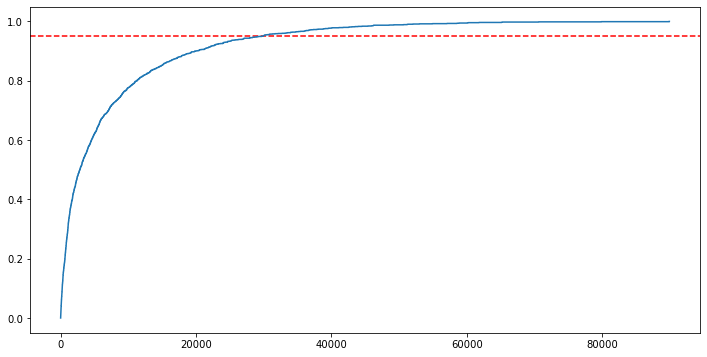

In [37]:
plt.figure(figsize=(12,6))
plt.axhline(.95, linestyle='--', c='r')
plt.plot(cum_pct);

In [41]:
tstamp=time()
G0_filtered, _ = PMFG(G0, verbose=0, tol_ratio=.03).compute()
print('Time taken: %.2f s' %(time()-tstamp))

Time taken: 43.11 s


In [42]:
print(networkx.info(G0_filtered))

Name: 
Type: Graph
Number of nodes: 503
Number of edges: 1461
Average degree:   5.8091


## Findings
It takes progressively longer to find the successive edge to be added to PMFG. The last few edges take more than twice the time than to find the rest (total ~120s, $97\%$ of the edges are found at ~40s and $40\%$ iteration). We are thinking in terms of running this algorithm on years worth of daily data. If we take the cutoff at 97% (so a planar-97%-filtered-graph instead of p-M-f-g), we cut runtime down to one-third.

Still, 40s ($=\epsilon$ for the other graph operations that we have to perform) per run mean a year's worth of business data would take ~3 hours to process. Relatively better and more manageable, but we can do better.

Proposal: use graph sampling method to compute centrality features of a random subgraph og the correlation network; do this multiple times to get some kind of sampled/ensembled centrality feature that hopefully captures most of the underlying structure of the corr. network, but runs way faster. (TBD)

## Centrality fFeature Analysis
Running the same plots to check that the distribution of centrality features of our approx. PMFG are in-line with the actual PMFG.

In [43]:
import networkx as nx

In [44]:
G1 = nx.Graph()
weight_map = lambda w: 1+w
for u,v,d in G0_filtered.edges(data=True):
    G1.add_edge(u,v,weight=weight_map(d['weight']))
print(nx.info(G1))

deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1), orient='index', columns = ['EC'])
PG =  pd.DataFrame.from_dict(nx.pagerank(G1), orient='index', columns = ['PG'])

Name: 
Type: Graph
Number of nodes: 503
Number of edges: 1461
Average degree:   5.8091


In [45]:
G1 = nx.Graph()
weight_map = lambda w: np.sqrt(2*(1-w))
for u,v,d in G0_filtered.edges(data=True):
    G1.add_edge(u,v,weight=weight_map(d['weight']))
print(nx.info(G1))

ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1), orient='index', columns = ['C'])
BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1), orient='index', columns = ['BC'])

Name: 
Type: Graph
Number of nodes: 503
Number of edges: 1461
Average degree:   5.8091


In [46]:
#centralities_names = ['BC', 'C', 'D', 'E', 'EC']
#centralities_names = ['D', 'BC', 'E', 'C', 'EC']
centralities_names = ['D', 'BC', 'nE', 'C', 'EC', 'PG']

centralities = deg.copy()
centralities['BC'] = BC
centralities['nE']  = -ecc
centralities['C']  = clo
centralities['EC'] = EC
centralities['PG'] = PG

print(centralities.head())

               D        BC  nE         C        EC        PG
GOOGL   8.474581  0.000038 -15  0.118424  0.001126  0.001844
GOOG    5.356738  0.000000 -15  0.117979  0.000543  0.001253
MSFT   24.632331  0.029429 -14  0.133582  0.003283  0.004888
FB     12.930859  0.001580 -15  0.118508  0.001318  0.002735
ADBE   33.734881  0.029288 -14  0.133831  0.005770  0.006522


In [47]:
centralities.corr()

,D,BC,nE,C,EC,PG
D,1.000000,0.782564,0.183977,0.316549,0.619908,0.992458
BC,0.782564,1.000000,0.198693,0.340637,0.649174,0.764227
nE,0.183977,0.198693,1.000000,0.938779,0.616291,0.151875
C,0.316549,0.340637,0.938779,1.000000,0.747636,0.268181
EC,0.619908,0.649174,0.616291,0.747636,1.000000,0.596356
PG,0.992458,0.764227,0.151875,0.268181,0.596356,1.000000


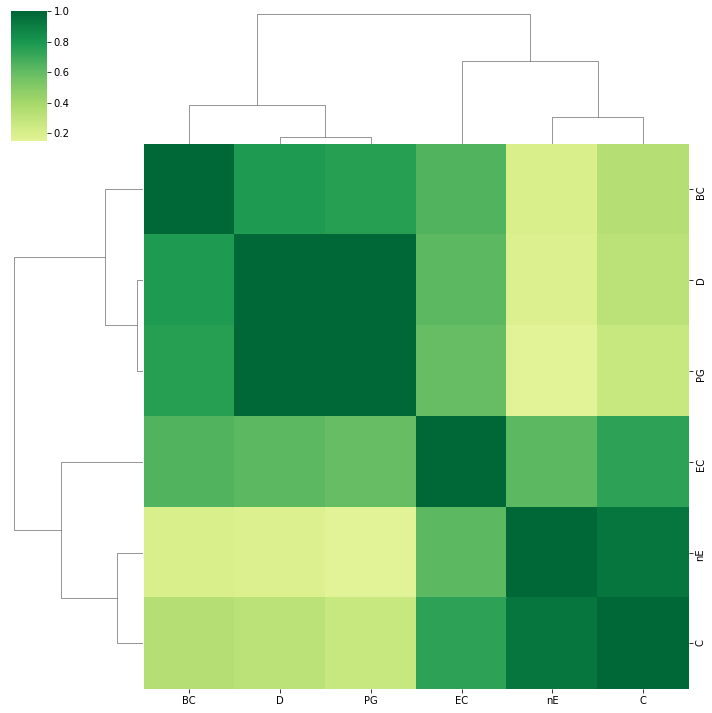

In [48]:
import seaborn as sns

sns.clustermap(centralities.corr(), cmap="RdYlGn", center=0.)
plt.show()

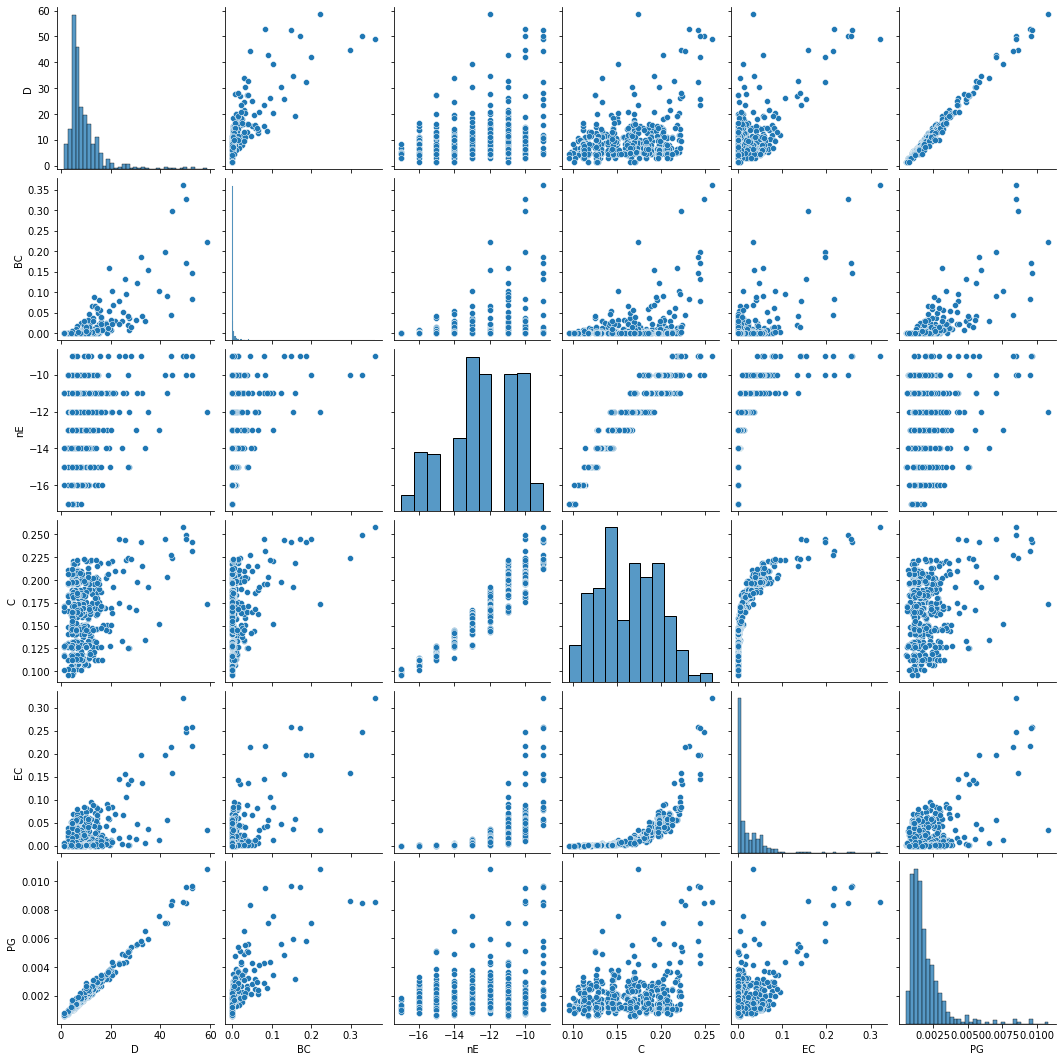

In [49]:
corr_plot = sns.pairplot(data=centralities);

#corr_plot.map_lower(sns.kdeplot, levels=4, color=".2");

BC    EMR
dtype: object


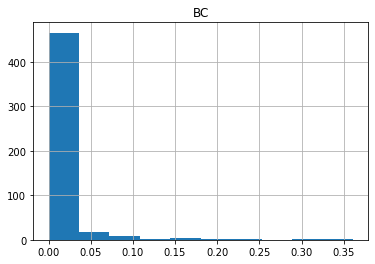

In [50]:
print(BC.idxmax())
BC.hist();